# Author: Samuel Hickey

### Word-level (notes and chords treated as singular words) Music Generating RNN
### Version 2.0: Next Word Prediction

In version 1, we followed the Tensorflow tutorial from Magenta to attempt to generate Music using RNNs.

In version 2, we will diverge from the approach of V1 and attempt to generate notes in a manner similar to generating sentences in NLP.
We will train the model using next word prediction. Our vocabulary will consist of all notes and note combinations found in the Maestro v2 dataset (~12000 different combinations)


## Imports

In [1]:
import collections
import glob
import keras
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import warnings

from numba import jit
from keras.layers import (BatchNormalization, Bidirectional, CategoryEncoding, Embedding, Dense, Dropout, LSTM)
from keras.utils import timeseries_dataset_from_array
from keras.preprocessing.text import Tokenizer
from scipy import spatial
from utilities.DatasetUtils import plot_piano_roll

warnings.filterwarnings("ignore")

_SAMPLING_RATE = 16000
SEQ_LEN = 128

### Select Dataset

In [2]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
filenames = glob.glob(str(data_dir/'*/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### Extract the Notes

For each song, we round the start times of each note to the nearest one-thousandth of a second and consider any notes with the same start time to be a chord i.e. a new term in our vocabulary. Each step contains at least one key and as many as seven keys.

In [42]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
	pm = pretty_midi.PrettyMIDI(midi_file)
	instrument = pm.instruments[0]
	notes = collections.defaultdict(list)
	notes['pitch'].append('[START]')
	notes['start'].append(0)
	for note in sorted(instrument.notes, key=lambda note: note.start):
		notes['pitch'].append(pretty_midi.note_number_to_name(note.pitch))
		notes['start'].append(round(note.start, 3))
	notes['pitch'].append('[END]')
	notes['start'].append(round(note.start, 2) + 3)

	result = pd.DataFrame({name: np.array(value) for name, value in notes.items()}) \
		.groupby('start') \
		.agg({'pitch': sorted}) \
		.reset_index() \
		.pitch.str.join(',') \
		.to_frame()
	return result

# Load the files
num_files = len(filenames)
notes = []
for f in filenames[:num_files]:
    df = midi_to_notes(f)
    notes.append(df)
notes = pd.concat(notes).pitch

### Save Notes, Vocabulary, Character Indices

In [29]:
# Create a vocabulary, id-lookup, and note-lookup
vocab = np.unique(notes.to_numpy())
ids_from_notes = {v:k for k, v in enumerate(vocab)}
notes_from_ids = {k:v for k, v in enumerate(vocab)}
np.save(
    pathlib.Path('data/preprocessed/vocab_ids_notes.npy'),
    [vocab, ids_from_notes, notes_from_ids],
    allow_pickle=True
)
# Integer encode the notes
notes = notes.map(lambda note: ids_from_notes[note]) \
	.reset_index() \
	.pitch
np.save(
    pathlib.Path('data/preprocessed/notes.npy'),
    notes,
    allow_pickle=True
)

### Load Notes, Vocabulary, Character Indices

As mentioned earlier, the vocabulary and character indices were created using ALL of the available midi files in the Maestro V2 dataset.

In [33]:
vocab, ids_from_chars, chars_from_ids = np.load(
	'data/preprocessed/vocab_ids_notes.npy',
	allow_pickle=True
)
notes = np.load('data/preprocessed/notes.npy', allow_pickle=True)

### Create Dataset

Here we are using time_series_dataset_from_array to create batches of sequences that have a length of SEQ_LEN. Next, we map each batch over the split_input_target function to create an input of shape (batch_size, SEQ_LEN-1) and a target of shape (batch_size, 1). 

It is important to our understanding that we realize time_series_dataset_from_array will take a sequence of events [x1, x2, ...,  x_n] and produce a tensor of sequences: 

[[x1, x2, ..., x_seq_len], 
<br>[x_seq_len, x_seq_len+1, ..., x_seq_len*2],
<br>[  ...  ]
<br>[x_n-seq_len, x_n+1-seq_len, ..., x_n]]

Where [x_n-seq_len, x_n+1-seq_len, ..., x_n]] is the last sequence in the batch.

In [34]:
def split_input_target(seq):
    layer = CategoryEncoding(num_tokens=len(vocab)+1, output_mode="one_hot")
    inputs, targets = seq[:, :-1], seq[:, -1]
    return (
        inputs,
        layer(targets)
    )
dataset = timeseries_dataset_from_array(notes, None, SEQ_LEN, batch_size=64) \
    .map(split_input_target)

### Model Definition and Initialization

In [36]:
model = keras.models.Sequential([
    Embedding(len(vocab)+1, 128, input_length=SEQ_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(.2),
    Bidirectional(LSTM(128)),
    Dropout(.2),
    Dense(128, activation='relu'),
    Dense(len(vocab)+1, activation='softmax')
])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=.5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy')

### Training

In [ ]:
history = model.fit(dataset, epochs=200, callbacks=callbacks)

### Save the Model

In [ ]:
model.save(pathlib.Path(f'models/V2.0/EXPERIMENTAL/trained_on_{num_files}/seq_len_{SEQ_LEN}'))

# Supported Generation

### Load Model and Make Prediction

In [69]:
model = keras.models.load_model(f'models/V2.0/trained_on_{num_files}/seq_len_{SEQ_LEN}', custom_objects={'optimizer':optimizer})

# Prediction
num_steps = 256
preds = model(list(timeseries_dataset_from_array(notes[SEQ_LEN:SEQ_LEN*13], targets=None, sequence_length=SEQ_LEN, batch_size=num_steps))[0]).numpy()

### Extract Input & Target Sequence to DataFrame

In [70]:
# Inputs
to_notes = np.vectorize(lambda x: notes_from_ids[x].split(','))
orig = list(map(to_notes, notes[SEQ_LEN:SEQ_LEN*13]))
notes_ = []
start = []
j = 0.75
for i in orig:
    temp = .2
    j += temp
    notes_.append((i[0], j, j+.1, .1, temp))
orig_df = pd.DataFrame(notes_, columns=['pitch', 'start', 'end', 'duration', 'step']).explode('pitch')


# Target
notes_ = []
start = []
j = 0.75
for i in range(len(preds)):
    temp = .2
    j += temp
    notes_.append((notes_from_ids[list(preds[i]).index(np.max(preds[i]))].split(','), j, j+.1, .1, temp))
notes_df = pd.DataFrame(notes_, columns=['pitch', 'start', 'end', 'duration', 'step']).explode('pitch')

### Extract Instrument

In [71]:
file = pretty_midi.PrettyMIDI(filenames[0])
instrument_name = pretty_midi.program_to_instrument_name(file.instruments[0].program)

### Save MIDI files

In [72]:
def df_to_midi(
        notes: pd.DataFrame,
        out_file: str, 
        instrument_name: str,
        velocity: int = 90,  # note loudness
) -> pretty_midi.PrettyMIDI:
    file = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
        instrument_name))
    for i, note in notes.iterrows():
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(pretty_midi.note_name_to_number(note['pitch'])),
            start=note['start'],
            end=note['end'],
        )
        instrument.notes.append(note)
    file.instruments.append(instrument)
    file.write(out_file)
ORIG_PATH = f'data/generated_files/V2.0/trained_on_{num_files}/seq_len_{SEQ_LEN}_steps_{num_steps}_input.midi'
GEN_PATH = f'data/generated_files/V2.0/trained_on_{num_files}/seq_len_{SEQ_LEN}_steps_{num_steps}.midi'
df_to_midi(orig_df, ORIG_PATH, instrument_name)
df_to_midi(notes_df, GEN_PATH, instrument_name)

### Prep and Plot the DataFrames

In [73]:
orig_df.pitch = orig_df.pitch.map(pretty_midi.note_name_to_number)
notes_df.pitch = notes_df.pitch.map(pretty_midi.note_name_to_number)

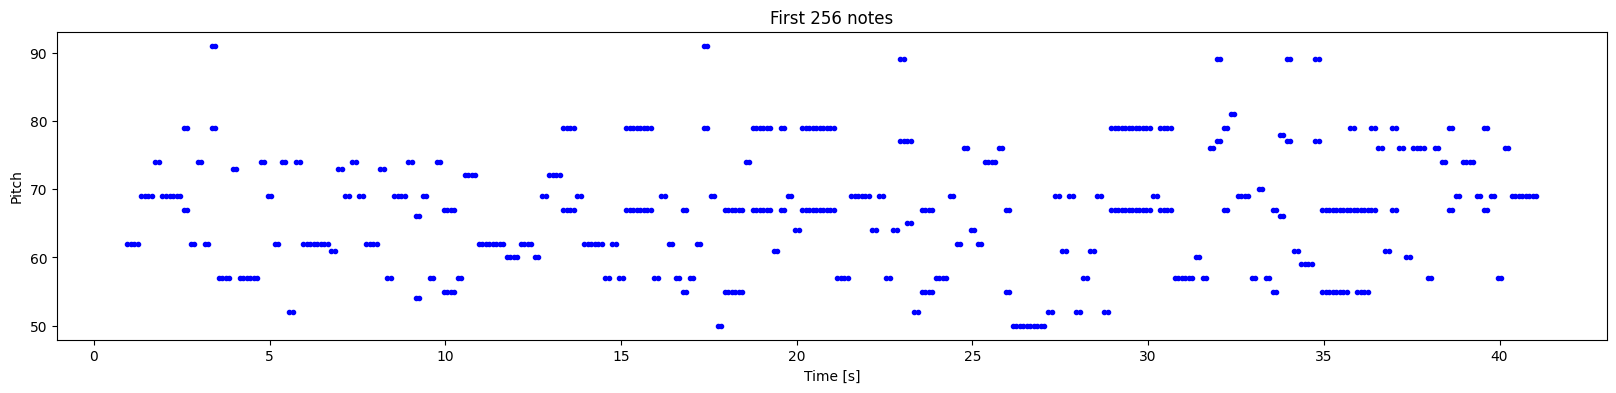

In [74]:
plot_piano_roll(notes_df, 256)

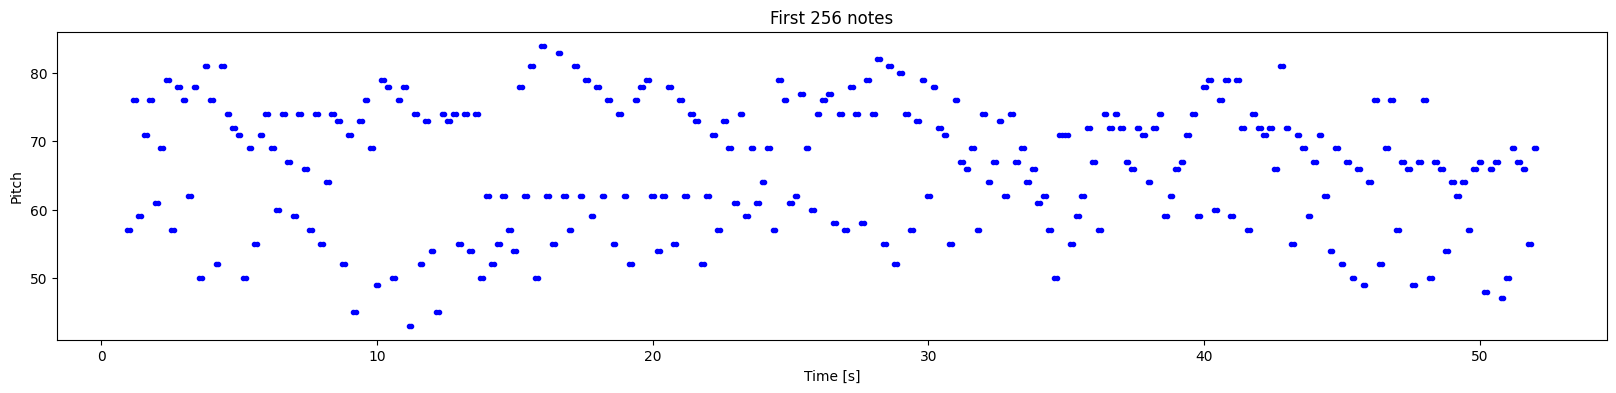

In [75]:
plot_piano_roll(orig_df, 256)

### Calculate the Cosine-Similarity between the original song and the predicted notes

In [76]:
predicted = midi_to_notes(GEN_PATH) \
    .iloc[1:-1] \
    .pitch \
    .map(lambda note: ids_from_chars[note]) \
    .to_numpy()
original = midi_to_notes(ORIG_PATH) \
    .iloc[:256] \
    .pitch \
    .map(lambda note: ids_from_chars[note]) \
    .to_numpy()

In [77]:
cos_sim = np.dot(predicted, original) \
    / (np.linalg.norm(predicted) * np.linalg.norm(original))
cos_sim

0.8661153431881068